# An Upper Limit Howto

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, norm, chi2
from scipy.optimize import minimize

We begin with defining our example. We have two spectra; a bump-like signal spectra upon the smooth background spectra. The parameters of this toy example are the two normalisation of these two components.

We assume that the data are a measured number of events in $n=30$ energy bins, and define a data generating function.

In [2]:
E = np.logspace(0,2,30+1)
E = (E[1:] + E[:-1]) / 2 # bin centers

def signal_shape(E=E, mu=10, var=2):
    return norm.pdf(E, mu, var)

def background_shape(E=E, gamma=-1):
    return E**gamma

def generate_data(bkg_norm, sig_norm, E=E, seed=None):
    np.random.seed(seed)
    return np.random.poisson(sig_norm * signal_shape(E) + 
                             bkg_norm * background_shape(E))

It's hard to visualise so we plot a realisation of the toy example.

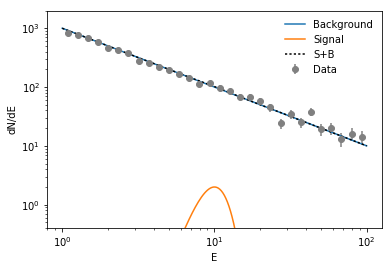

In [3]:
def visualise_model(bkg_norm, sig_norm):
    fig, ax = plt.subplots()
    x = np.logspace(0,2,200)
    b = bkg_norm*background_shape(x)
    s = sig_norm*signal_shape(x)
    ax.plot(x, b, label='Background')
    ax.plot(x, s, label='Signal')
    ax.plot(x, s+b, color='black', linestyle='dotted', label='S+B')

    N = generate_data(bkg_norm, sig_norm)
    ax.errorbar(E, N, yerr=np.sqrt(N), fmt='o', color='grey', label='Data')
    ax.set_ylim(0.4, 2*np.maximum(s.max(), b.max()))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('E')
    ax.set_ylabel('dN/dE')
    ax.legend(frameon=False)
    return fig, ax

visualise_model(bkg_norm=1000, sig_norm=10);

## Defining the likelihood and the test statistics

The likelihood is simply the product of poisson distributions for each bin.

In [4]:
def lnLike(bkg_norm, sig_norm, data, gamma=-1, mu=10, var=2):
    s = sig_norm*signal_shape(mu=mu, var=var)
    b = bkg_norm*background_shape(gamma=gamma)
    return np.log(poisson.pmf(data, mu=s+b)).sum()

def TS(sig_norm, data, bestfit=None):
    numerator = minimize(lambda b: -2*lnLike(b, sig_norm, data), 1e3)
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    return numerator.fun - bestfit.fun

## Visualising the properties of the test statistics

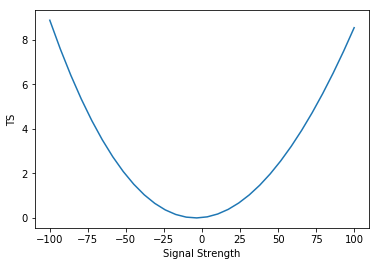

In [5]:
data = generate_data(1000, 0, seed=42)
bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
x = np.linspace(-100, 100, 30)
y = [TS(s, data, bestfit=bestfit) for s in x]

plt.plot(x, y);
plt.xlabel('Signal Strength')
plt.ylabel('TS');

We can also look at the background strength by defining the appropriate test statistics.

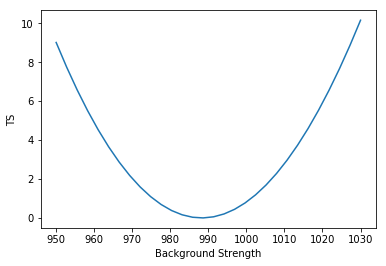

In [6]:
def TSb(bkg_norm, data, bestfit=None):
    numerator = minimize(lambda s: -2*lnLike(bkg_norm, s, data), 1e3)
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    return numerator.fun - bestfit.fun

x = np.linspace(950, 1030, 30)
y = [TSb(b, data, bestfit=bestfit) for b in x]

plt.plot(x, y);
plt.xlabel('Background Strength')
plt.ylabel('TS');

## Verifying that Wilk's theorem applies

In [7]:
ts = []
for k in [0, 100, 1000]:
    if k in ts:
        ts[k] = list(ts[k])
    else:
        ts[k] = []

for _ in range(200):
    d = generate_data(1000, 0)
    bf = minimize(lambda x: -2*lnLike(x[0], x[1], d), (1e3,1e3))

    for k in ts:
        r = minimize(lambda s: TS(s, d, bestfit=bf), k)
        ts[k].append(r.fun)

for k in ts:
    ts[k] = np.array(ts[k])

NameError: name 'ts' is not defined

In [11]:
ts = {}
for k in ts:
    np.savetxt('ts_%i.txt' % k, ts[k])

As running the above monte carlo is quite slow, we've stored the results to disk.

In [12]:
for k in [0,100,1000]:
    ts[k] = np.loadtxt('ts_%i.txt' % k)

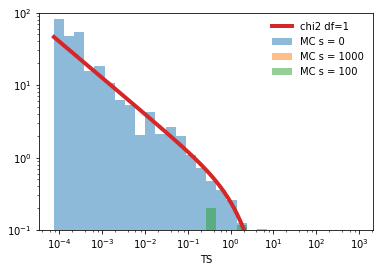

In [13]:
for k in [0, 100, 1000]:
    #ts[k] = {}
    ts[k] = np.array(ts[k])

max_ts = np.max([ts[k].max() for k in ts])
min_ts = np.abs(np.min([ts[k].min() for k in ts]))
bins = np.logspace(np.log10(min_ts), np.log10(max_ts)*1.1, 31)

for k in ts:
    plt.hist(ts[k], bins=bins, label='MC s = %i' % k,
             normed=True, alpha=0.5)

x = np.logspace(np.log10(min_ts), np.log10(max_ts), 100)
#x = np.linspace(0.1, 10, 100)
plt.plot(x, chi2.pdf(x, df=1), lw=4, label='chi2 df=1')
plt.legend(frameon=False)
plt.xlabel('TS')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1, 100);

In [14]:
ts_100 = []
for _ in range(200):
    d = generate_data(1000, 0)
    bf = minimize(lambda x: -2*lnLike(x[0], x[1], d), (1e3,1e3))
    r = minimize(lambda s: TS(s, d, bestfit=bf), 100)
    ts_null.append(r.fun)
ts_null = np.array(ts_null)

KeyboardInterrupt: 

In [ ]:
def 